In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cpu')

# Domik Dataset

In [37]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [36]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [35]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

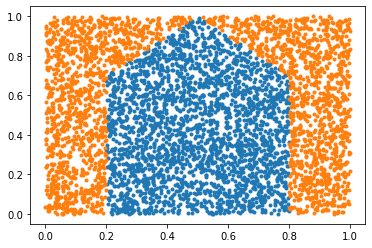

In [38]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

## Net

In [39]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)


In [40]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


## Train

Let's split learning process into 2 parts: with high and lower learning rate

Epoch        0 Loss: 0.1164643173206448
Epoch        1 Loss: 0.06510402338126942
Epoch        2 Loss: 0.052487782060079737
Epoch        3 Loss: 0.05098142272149137
Epoch        4 Loss: 0.04712702024147938
Epoch        5 Loss: 0.04439719969409958
Epoch        6 Loss: 0.0422095543548614
Epoch        7 Loss: 0.041161461344481225
Epoch        8 Loss: 0.03909228955708061
Epoch        9 Loss: 0.03619673229052488


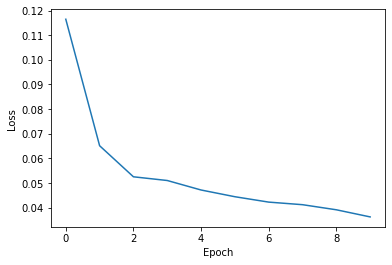

In [41]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), #BCELoss, CrossEntropyLoss MSELoss
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.01862216727176243
Epoch        1 Loss: 0.016896669978858154
Epoch        2 Loss: 0.016369636631086513
Epoch        3 Loss: 0.015924889520362716
Epoch        4 Loss: 0.015578886768917432
Epoch        5 Loss: 0.015246024222310126
Epoch        6 Loss: 0.01494562364229377
Epoch        7 Loss: 0.014668773872367475
Epoch        8 Loss: 0.014409485881361254
Epoch        9 Loss: 0.014176238254588941
Epoch       10 Loss: 0.013960551755015363
Epoch       11 Loss: 0.013760703825005455
Epoch       12 Loss: 0.013521233135231073
Epoch       13 Loss: 0.013412742088677545
Epoch       14 Loss: 0.013234592084580289
Epoch       15 Loss: 0.0130533551345685
Epoch       16 Loss: 0.012868119888950435
Epoch       17 Loss: 0.012733623282585014
Epoch       18 Loss: 0.012557152594514608
Epoch       19 Loss: 0.012434037305350906


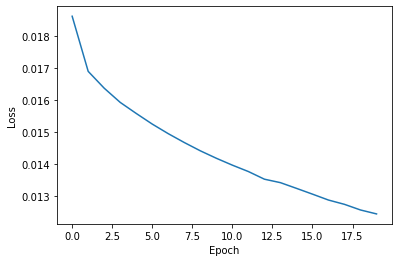

In [42]:
# then learning with low rate
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), #BCELoss, CrossEntropyLoss MSELoss
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

Accuracy of the network on the 25000 test samples: 98.904


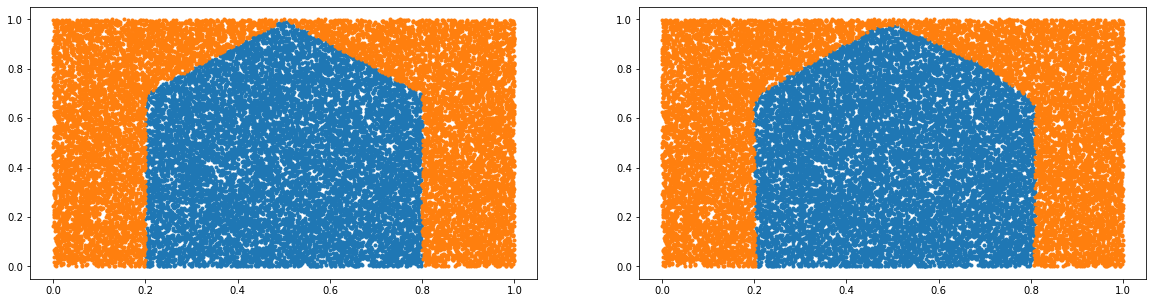

In [43]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes

In [44]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

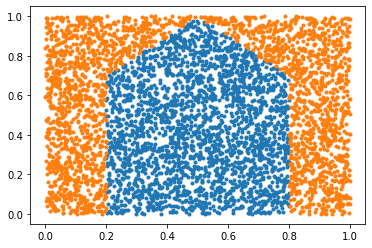

In [45]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [47]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)


## Train

Let's split learning process into 2 parts: with high and lower learning rate

Epoch        0 Loss: 0.54568671088735
Epoch        1 Loss: 0.2184665473241579
Epoch        2 Loss: 0.15823832956199743
Epoch        3 Loss: 0.13598780445223585
Epoch        4 Loss: 0.12586401583219475
Epoch        5 Loss: 0.1186425834983135
Epoch        6 Loss: 0.11089123430010878
Epoch        7 Loss: 0.10568595704631487
Epoch        8 Loss: 0.10066214437265769
Epoch        9 Loss: 0.09657666086156433
Epoch       10 Loss: 0.09436998958050248
Epoch       11 Loss: 0.09142702828215235
Epoch       12 Loss: 0.08946534238229137
Epoch       13 Loss: 0.08776542629645723
Epoch       14 Loss: 0.08562384325423568
Epoch       15 Loss: 0.08423012834179046
Epoch       16 Loss: 0.08290387037645512
Epoch       17 Loss: 0.0818994643213287
Epoch       18 Loss: 0.07935253546372634
Epoch       19 Loss: 0.07892581785637344


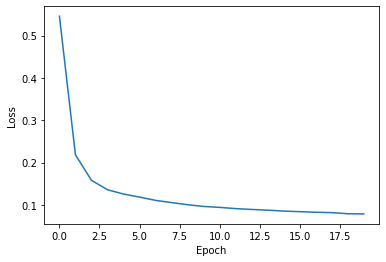

In [48]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.04326133241889633
Epoch        1 Loss: 0.041436973751825014
Epoch        2 Loss: 0.04082139580748513
Epoch        3 Loss: 0.040361283201279644
Epoch        4 Loss: 0.040005098505060135
Epoch        5 Loss: 0.039687729634646916
Epoch        6 Loss: 0.03940988520854243
Epoch        7 Loss: 0.039166921292570586
Epoch        8 Loss: 0.038912916304632346
Epoch        9 Loss: 0.038640414219541924
Epoch       10 Loss: 0.03841228495106422
Epoch       11 Loss: 0.03819895789020316
Epoch       12 Loss: 0.037973488908203464
Epoch       13 Loss: 0.037769691899593394
Epoch       14 Loss: 0.03754592633389454
Epoch       15 Loss: 0.0373524757041108
Epoch       16 Loss: 0.03715592752041519
Epoch       17 Loss: 0.03696547826984258
Epoch       18 Loss: 0.036782183175693484
Epoch       19 Loss: 0.03660053718774916
Epoch       20 Loss: 0.036421865540510724
Epoch       21 Loss: 0.036244684209152715
Epoch       22 Loss: 0.03607155929030371
Epoch       23 Loss: 0.035897841563338896
Epoc

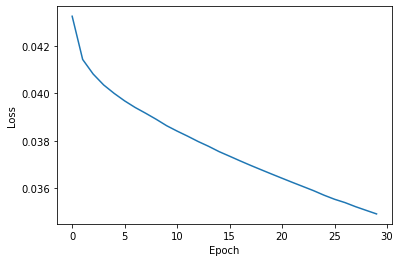

In [49]:
# then learning with low rate 
EPOCHS_TO_TRAIN = 30
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

In [50]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 99.248


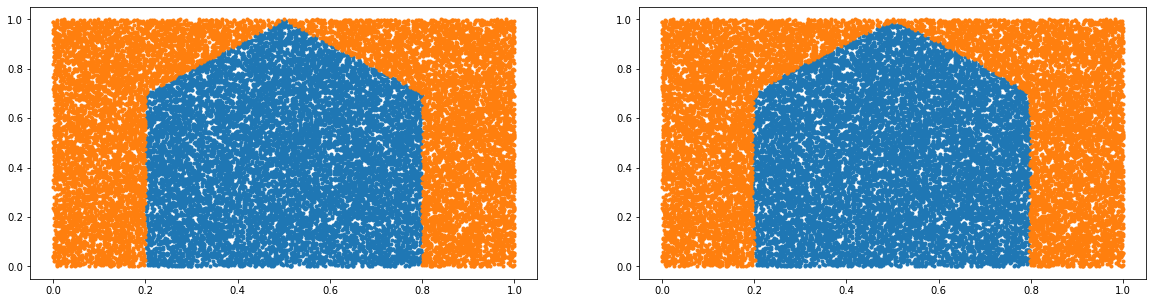

In [51]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [52]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

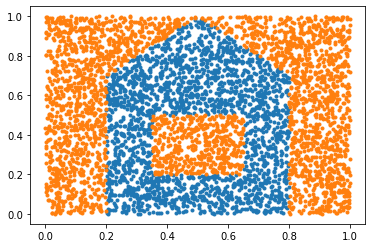

In [53]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [67]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.2248656686298818
Epoch        1 Loss: 0.17680234688936183
Epoch        2 Loss: 0.1597264876976851
Epoch        3 Loss: 0.14167863974259762
Epoch        4 Loss: 0.1331325204919988
Epoch        5 Loss: 0.12486556019229379
Epoch        6 Loss: 0.11805151398414135
Epoch        7 Loss: 0.1160902400586627
Epoch        8 Loss: 0.11492686035659508
Epoch        9 Loss: 0.11661290948746468


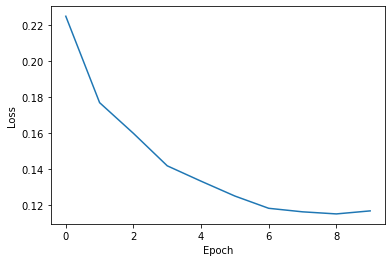

In [68]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

Epoch        0 Loss: 0.052079235763410156
Epoch        1 Loss: 0.038869563154070884
Epoch        2 Loss: 0.03609554909141723
Epoch        3 Loss: 0.03481134086413541
Epoch        4 Loss: 0.03345777806372906
Epoch        5 Loss: 0.03241861852807024
Epoch        6 Loss: 0.031572763584199956
Epoch        7 Loss: 0.03093717856394074
Epoch        8 Loss: 0.030231068865213838
Epoch        9 Loss: 0.029780505699254656


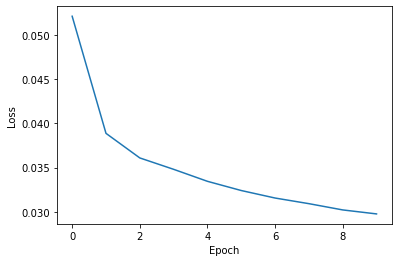

In [69]:
# continue learning with low rate
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

Epoch        0 Loss: 0.02437257596565856
Epoch        1 Loss: 0.023617183286369726
Epoch        2 Loss: 0.023364007725484727
Epoch        3 Loss: 0.023152875979307114
Epoch        4 Loss: 0.02296290995014388
Epoch        5 Loss: 0.022756705494744046
Epoch        6 Loss: 0.022579135990940497
Epoch        7 Loss: 0.022406296059363666
Epoch        8 Loss: 0.022234122298453604
Epoch        9 Loss: 0.022082283483916262
Epoch       10 Loss: 0.02191595169129766
Epoch       11 Loss: 0.021773806072262956
Epoch       12 Loss: 0.0216320312481496
Epoch       13 Loss: 0.02149137063920213
Epoch       14 Loss: 0.021358326391370745
Epoch       15 Loss: 0.02123815272689831
Epoch       16 Loss: 0.02110416857725522
Epoch       17 Loss: 0.02098188815337679
Epoch       18 Loss: 0.020865636878364423
Epoch       19 Loss: 0.020744585004609326


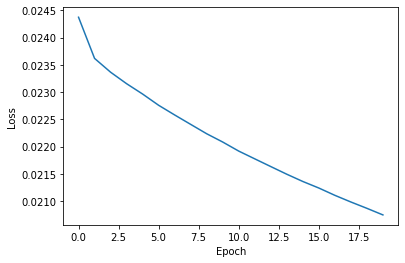

In [70]:
#  learning with lower rate
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.002))

Epoch        0 Loss: 0.020059381796073906
Epoch        1 Loss: 0.01992422755220627
Epoch        2 Loss: 0.019863095407024557
Epoch        3 Loss: 0.019805401147056697
Epoch        4 Loss: 0.0197517496451353
Epoch        5 Loss: 0.019692312061190115
Epoch        6 Loss: 0.01964392314289729
Epoch        7 Loss: 0.019586784927504715
Epoch        8 Loss: 0.019541988288254028
Epoch        9 Loss: 0.019484837637792397


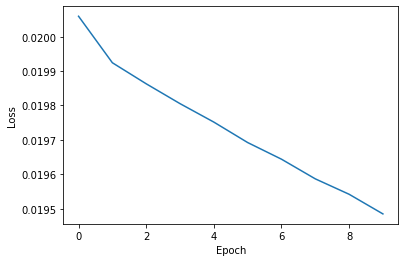

In [71]:
#  finish learning with lower rate
EPOCHS_TO_TRAIN = 10
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

Accuracy of the network on the 25000 test samples: 98.684


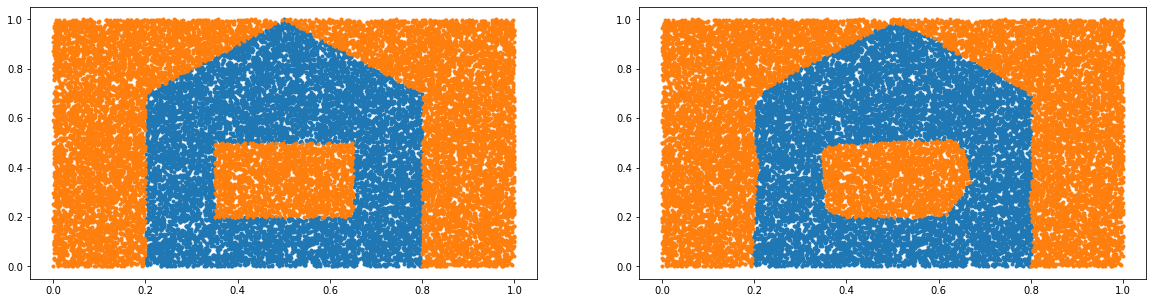

In [72]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [73]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

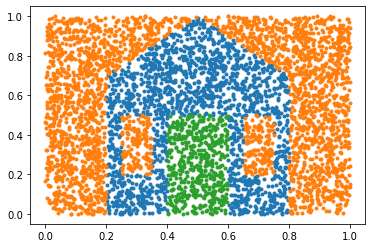

In [74]:
DATASET_SIZE = 5000
domik = DoorDomikDataset(DATASET_SIZE)
domik.show()

## Net

In [75]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


## Train

In [76]:
# learning first epochs with high rate 
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

IndexError: Target 1 is out of bounds.

## Test

In [ ]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

In [ ]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)